In [1]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import os
import time
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50
from pytorchcv.model_provider import get_model as ptcv_get_model

In [2]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =448
        self.n_augment = max(n_augment , 4)
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224)),
                transforms.RandomRotation(5),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ]
            )
        self.training = training
        for label in range(num_classes):
            self.data_dir = os.path.join(root,os.listdir(root)[label])
            self.filename = os.listdir(self.data_dir)
            l = len(self.filename)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(self.data_dir , self.filename[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))
    
    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        return len(self.data_path)*self.n_augment

In [3]:
# del training_dataloader
batch_size = 128
lr = 0.1
suffix = '%f' % time.time()
log_dir = './log/%s'% suffix +'/'
EXPERIMENT = 'resnet50_%s'% str(lr)
os.mkdir(log_dir)
print(suffix)
print(log_dir)
print(EXPERIMENT)

training_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)

1592643662.118069
./log/1592643662.118069/
resnet50_0.1


In [4]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every  iterations, print loss
        if (i + 1) % (10) == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [5]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy,cm

In [6]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [7]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    cms = []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        loss = train(model, training_dataloader, loss_func, optimizer, device)
        losses.append(loss)
        schedulr.step()
        
        # evaluate step
        accuracy,cm = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        cms.append(cm)
        torch.save(cm,log_dir+str(epoch)+'_cms.pth')   
        torch.save(loss,log_dir+str(epoch)+'_tls.pth')   
        torch.save(accuracy,log_dir+str(epoch)+'_tas.pth')   
    torch.save(cms,log_dir+EXPERIMENT+'_cms.pth')   
    torch.save(losses,log_dir+EXPERIMENT+'_tls.pth')   
    torch.save(accs,log_dir+EXPERIMENT+'_tas.pth')   
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [8]:
net = ptcv_get_model("resnet18", num_classes=40)

In [9]:
# Hyper-parameters
num_epochs = 40
nclasses = 40
feature_tune=False
# Device configuration
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# # optimizer
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 4 , gamma = 0.5)

Epoch 1/40: , lr = 0.2
Step [10/60] Train Loss: 4.4691
Step [20/60] Train Loss: 3.7405
Step [30/60] Train Loss: 3.3953
Step [40/60] Train Loss: 3.2791
Step [50/60] Train Loss: 3.1662
Step [60/60] Train Loss: 3.2232
Accuracy on Test Set: 8.9583 %


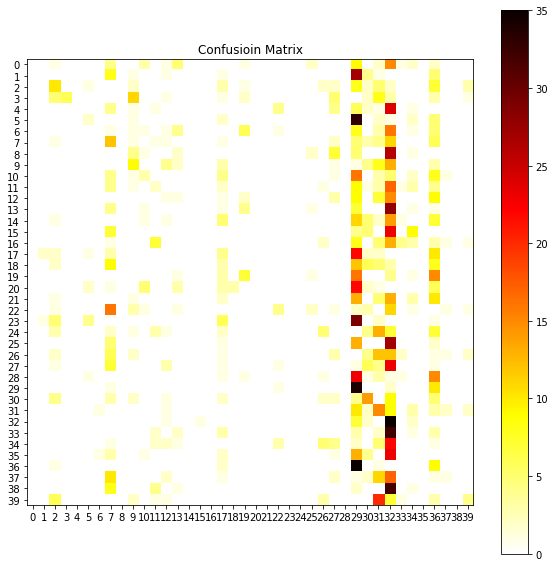

Accuracy of each class:
 tensor([0.0000, 0.0000, 0.2083, 0.1250, 0.0000, 0.0417, 0.0000, 0.2500, 0.0000,
        0.1875, 0.0625, 0.0417, 0.0208, 0.0000, 0.0000, 0.0000, 0.0000, 0.0833,
        0.0000, 0.1458, 0.0000, 0.0000, 0.0833, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.7083, 0.2917, 0.3125, 0.7292, 0.0000, 0.0000, 0.0000,
        0.1875, 0.0208, 0.0000, 0.0833])
Recall of each class:
 tensor([0.0000, 0.0000, 0.2174, 1.0000, 0.0000, 0.1818, 0.0000, 0.0968, 0.0000,
        0.2045, 0.1765, 0.0870, 0.0435, 0.0000, 0.0000, 0.0000, 0.0000, 0.0656,
        0.0000, 0.2917, 0.0000, 0.0000, 0.2857, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0791, 0.1750, 0.0968, 0.0680, 0.0000, 0.0000, 0.0000,
        0.0503, 0.1429, 0.0000, 0.2857])
Epoch 2/40: , lr = 0.2
Step [10/60] Train Loss: 3.1937
Step [20/60] Train Loss: 3.0333
Step [30/60] Train Loss: 3.1334
Step [40/60] Train Loss: 3.0817
Step [50/60] Train Loss: 3.1278
Step [60/60] Train Loss: 3.0555
Accuracy on Tes

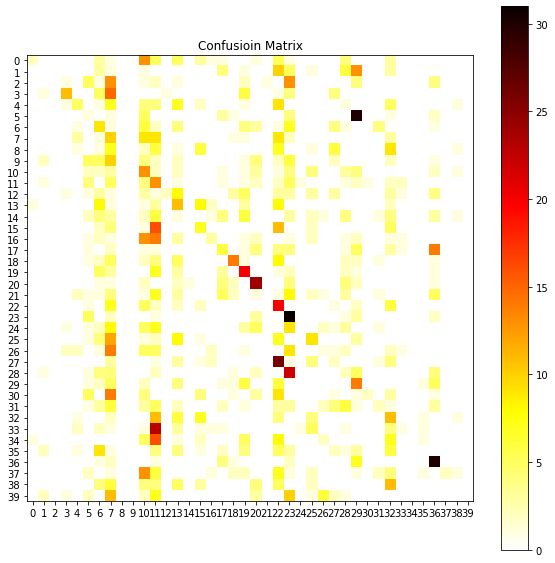

Accuracy of each class:
 tensor([0.0417, 0.0000, 0.0000, 0.2292, 0.1042, 0.0208, 0.1875, 0.2083, 0.0000,
        0.0000, 0.2708, 0.2708, 0.0417, 0.2292, 0.0000, 0.1458, 0.0625, 0.1250,
        0.2917, 0.4167, 0.5000, 0.0000, 0.4167, 0.6458, 0.0000, 0.1875, 0.0208,
        0.0417, 0.0417, 0.2917, 0.0417, 0.0417, 0.2292, 0.0208, 0.0000, 0.0000,
        0.6250, 0.0417, 0.0000, 0.0000])
Recall of each class:
 tensor([0.5000, 0.0000, 0.0000, 0.6111, 0.2778, 0.0227, 0.0989, 0.0505, 0.0000,
        0.0000, 0.0942, 0.0647, 0.6667, 0.1134, 0.0000, 0.1458, 0.2308, 0.1429,
        0.4828, 0.2597, 0.3750, 0.0000, 0.1093, 0.1856, 0.0000, 0.2045, 0.0667,
        0.0606, 0.0400, 0.1333, 0.6667, 0.1538, 0.1048, 0.1429, 0.0000, 0.0000,
        0.3571, 1.0000, 0.0000, 0.0000])
Epoch 3/40: , lr = 0.2
Step [10/60] Train Loss: 2.8813
Step [20/60] Train Loss: 2.9864
Step [30/60] Train Loss: 3.1378
Step [40/60] Train Loss: 2.8253
Step [50/60] Train Loss: 2.8709
Step [60/60] Train Loss: 2.7736
Accuracy on Tes

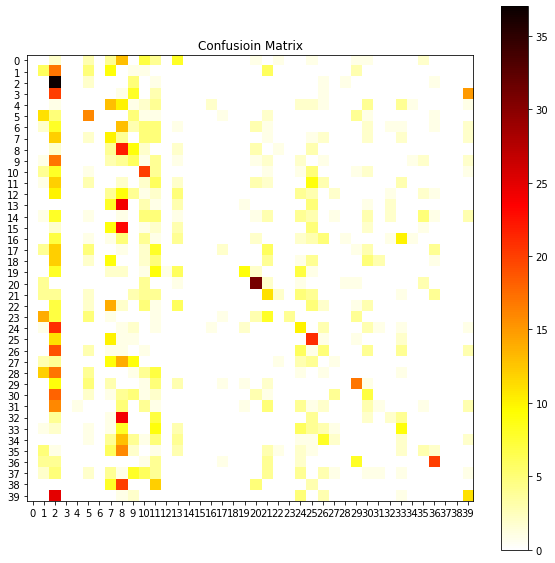

Accuracy of each class:
 tensor([0.0000, 0.1250, 0.7708, 0.0000, 0.0000, 0.3333, 0.0000, 0.2083, 0.4583,
        0.1250, 0.4167, 0.1250, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0417,
        0.0000, 0.1875, 0.6458, 0.2292, 0.0000, 0.0833, 0.2083, 0.4375, 0.1042,
        0.0208, 0.0000, 0.3542, 0.1458, 0.0208, 0.0417, 0.1875, 0.0000, 0.0625,
        0.4167, 0.0000, 0.0000, 0.2292])
Recall of each class:
 tensor([0.0000, 0.0750, 0.0989, 0.0000, 0.0000, 0.2353, 0.0000, 0.0719, 0.0898,
        0.0759, 0.2062, 0.0448, 0.0000, 0.0536, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000, 0.6429, 0.5345, 0.1618, 0.0000, 1.0000, 0.1370, 0.2234, 0.1111,
        0.0833, 0.0000, 0.4048, 0.1400, 0.1667, 0.2222, 0.1875, 0.0000, 0.1579,
        0.5556, 0.0000, 0.0000, 0.2340])
Epoch 4/40: , lr = 0.2
Step [10/60] Train Loss: 2.8151
Step [20/60] Train Loss: 2.6746
Step [30/60] Train Loss: 2.8026
Step [40/60] Train Loss: 2.7327
Step [50/60] Train Loss: 2.5786
Step [60/60] Train Loss: 2.7401
Accuracy on Tes

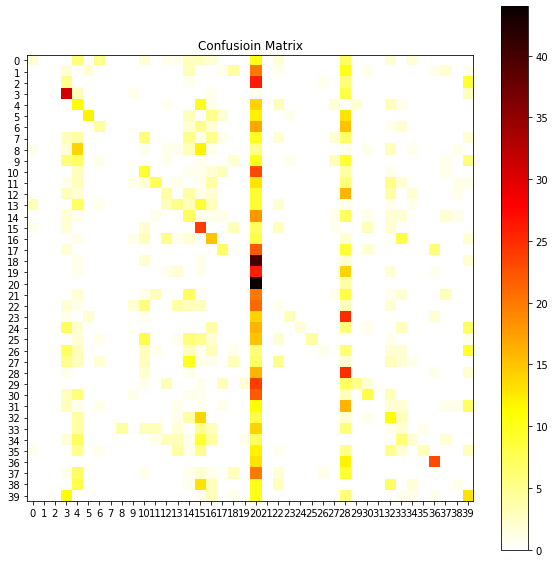

Accuracy of each class:
 tensor([0.0417, 0.0000, 0.0000, 0.6458, 0.2292, 0.2500, 0.0833, 0.0000, 0.0000,
        0.0000, 0.1875, 0.1458, 0.0833, 0.1042, 0.1458, 0.5000, 0.3125, 0.1458,
        0.0000, 0.0000, 0.9167, 0.0000, 0.0208, 0.0625, 0.0417, 0.0833, 0.0208,
        0.0000, 0.5208, 0.1042, 0.1667, 0.0000, 0.2292, 0.0417, 0.0417, 0.0625,
        0.4792, 0.0000, 0.0208, 0.2708])
Recall of each class:
 tensor([0.2500, 0.0000, 0.0000, 0.3039, 0.0924, 0.7500, 0.2500, 0.0000, 0.0000,
        0.0000, 0.1607, 0.4375, 0.1739, 0.1852, 0.0921, 0.1805, 0.2206, 0.3684,
        0.0000, 0.0000, 0.0721, 0.0000, 0.0370, 0.6000, 1.0000, 1.0000, 0.3333,
        0.0000, 0.0887, 0.7143, 0.4000, 0.0000, 0.1719, 0.0500, 0.1667, 0.7500,
        0.6571, 0.0000, 0.1667, 0.1912])
Epoch 5/40: , lr = 0.1
Step [10/60] Train Loss: 2.2839
Step [20/60] Train Loss: 2.2824
Step [30/60] Train Loss: 2.3980
Step [40/60] Train Loss: 2.3725
Step [50/60] Train Loss: 2.2874
Step [60/60] Train Loss: 2.2469
Accuracy on Tes

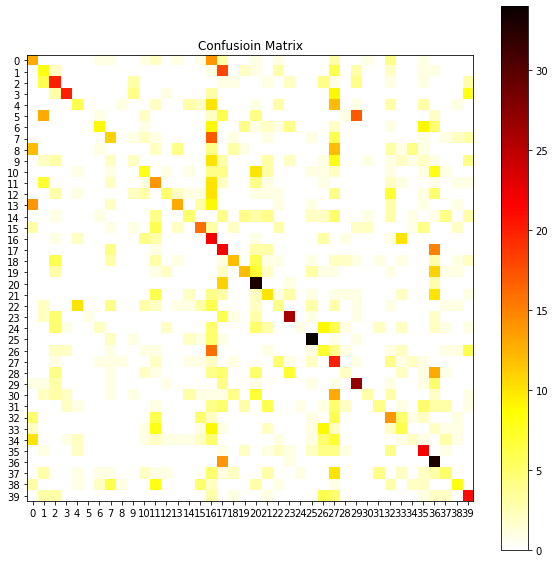

Accuracy of each class:
 tensor([0.2708, 0.1667, 0.4167, 0.4167, 0.1250, 0.0000, 0.1875, 0.2292, 0.0000,
        0.0417, 0.1667, 0.2917, 0.1042, 0.2708, 0.1042, 0.3333, 0.4583, 0.4583,
        0.2500, 0.2500, 0.6875, 0.2083, 0.0833, 0.5417, 0.0208, 0.7083, 0.1458,
        0.4167, 0.0417, 0.5625, 0.0625, 0.0833, 0.2917, 0.1250, 0.0417, 0.4583,
        0.6875, 0.1042, 0.1667, 0.4375])
Recall of each class:
 tensor([0.2063, 0.1600, 0.2941, 0.7143, 0.2222, 0.0000, 0.4737, 0.2444, 0.0000,
        0.1333, 0.2500, 0.1818, 0.3571, 0.5200, 0.2500, 0.3810, 0.1095, 0.1849,
        0.4286, 0.4286, 0.3173, 0.2041, 0.1429, 0.5417, 0.3333, 0.5965, 0.1296,
        0.1235, 0.1667, 0.4500, 0.3750, 0.3636, 0.2121, 0.1538, 0.1429, 0.3438,
        0.2481, 0.1923, 0.3636, 0.3818])
Epoch 6/40: , lr = 0.1
Step [10/60] Train Loss: 2.1685
Step [20/60] Train Loss: 2.3037
Step [30/60] Train Loss: 2.3134
Step [40/60] Train Loss: 2.2468
Step [50/60] Train Loss: 2.2363
Step [60/60] Train Loss: 2.0093
Accuracy on Tes

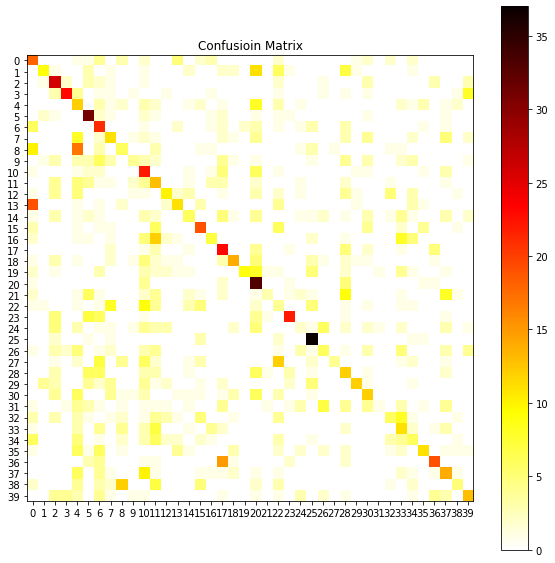

Accuracy of each class:
 tensor([0.3750, 0.1875, 0.5417, 0.4792, 0.2500, 0.6458, 0.4375, 0.2292, 0.1250,
        0.0833, 0.4583, 0.2708, 0.2083, 0.2292, 0.1250, 0.3958, 0.1458, 0.4792,
        0.2917, 0.1875, 0.6875, 0.0625, 0.0833, 0.4583, 0.0417, 0.7708, 0.1250,
        0.0833, 0.2500, 0.2500, 0.2500, 0.0208, 0.1250, 0.2292, 0.1250, 0.2292,
        0.3958, 0.2917, 0.1042, 0.2708])
Recall of each class:
 tensor([0.2169, 0.5000, 0.3171, 0.7188, 0.1062, 0.3780, 0.2000, 0.2157, 0.1500,
        0.3077, 0.1864, 0.1340, 0.3448, 0.3548, 0.2222, 0.3519, 0.2917, 0.2771,
        0.4516, 0.8182, 0.2727, 0.4286, 0.0606, 0.6286, 0.0952, 0.5068, 0.2143,
        0.8000, 0.1558, 0.6667, 0.2449, 0.3333, 0.2857, 0.1719, 0.1500, 0.4583,
        0.5429, 0.2373, 0.3333, 0.3714])
Epoch 7/40: , lr = 0.1
Step [10/60] Train Loss: 2.0527
Step [20/60] Train Loss: 2.0238
Step [30/60] Train Loss: 2.1899
Step [40/60] Train Loss: 2.1254
Step [50/60] Train Loss: 2.2614
Step [60/60] Train Loss: 2.1573
Accuracy on Tes

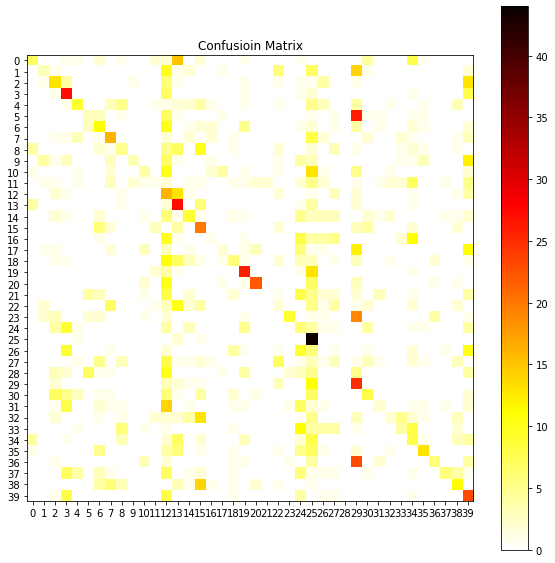

Accuracy of each class:
 tensor([0.1458, 0.0625, 0.2708, 0.5625, 0.1875, 0.0625, 0.2292, 0.3333, 0.1042,
        0.0625, 0.0833, 0.0208, 0.3333, 0.5625, 0.1875, 0.4167, 0.0208, 0.0417,
        0.1250, 0.5417, 0.4583, 0.0000, 0.0417, 0.1875, 0.1250, 0.9167, 0.0000,
        0.0625, 0.0000, 0.5208, 0.1667, 0.0417, 0.0417, 0.0833, 0.1667, 0.2708,
        0.1250, 0.1250, 0.2292, 0.4792])
Recall of each class:
 tensor([0.3333, 0.2143, 0.2708, 0.3034, 0.3462, 0.1579, 0.2000, 0.3200, 0.1613,
        0.5000, 0.2353, 0.0833, 0.0737, 0.2328, 0.2368, 0.2198, 0.0909, 0.1818,
        0.2400, 0.4483, 0.7333, 0.0000, 0.0588, 0.6923, 0.0625, 0.2115, 0.0000,
        0.0882, 0.0000, 0.1534, 0.2424, 0.1667, 0.2000, 0.2353, 0.1176, 0.5000,
        0.4615, 0.6000, 0.2895, 0.1855])
Epoch 8/40: , lr = 0.1
Step [10/60] Train Loss: 1.9767
Step [20/60] Train Loss: 1.9563
Step [30/60] Train Loss: 1.9666
Step [40/60] Train Loss: 2.0228
Step [50/60] Train Loss: 2.1554
Step [60/60] Train Loss: 1.7396
Accuracy on Tes

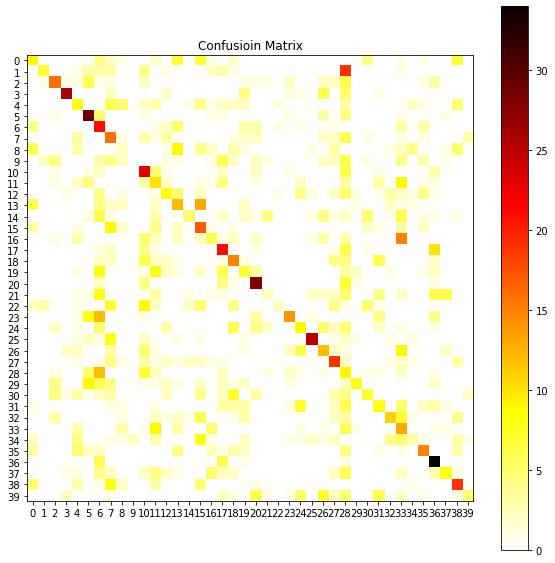

Accuracy of each class:
 tensor([0.1875, 0.1458, 0.3333, 0.5417, 0.1667, 0.6042, 0.4375, 0.3333, 0.0417,
        0.0000, 0.4792, 0.2083, 0.1667, 0.2500, 0.1042, 0.3542, 0.1250, 0.4375,
        0.3125, 0.1458, 0.5833, 0.0417, 0.0417, 0.2917, 0.1875, 0.5208, 0.2500,
        0.3958, 0.1875, 0.1667, 0.1458, 0.1667, 0.2292, 0.2708, 0.0625, 0.3125,
        0.7083, 0.1667, 0.3958, 0.1042])
Recall of each class:
 tensor([0.2195, 0.5385, 0.4211, 0.7647, 0.1600, 0.4028, 0.1667, 0.1739, 0.0800,
        0.0000, 0.2556, 0.1299, 0.2162, 0.2069, 0.4167, 0.2000, 0.1935, 0.2800,
        0.2586, 0.1750, 0.4444, 0.1667, 0.4000, 0.5185, 0.2368, 0.7353, 0.2353,
        0.3115, 0.0600, 0.5333, 0.2593, 0.2000, 0.4400, 0.1300, 0.2000, 0.3947,
        0.4304, 0.3810, 0.3654, 0.4545])
Epoch 9/40: , lr = 0.05
Step [10/60] Train Loss: 1.4641
Step [20/60] Train Loss: 1.7889
Step [30/60] Train Loss: 1.5608
Step [40/60] Train Loss: 1.8161
Step [50/60] Train Loss: 1.5109
Step [60/60] Train Loss: 1.6067
Accuracy on Te

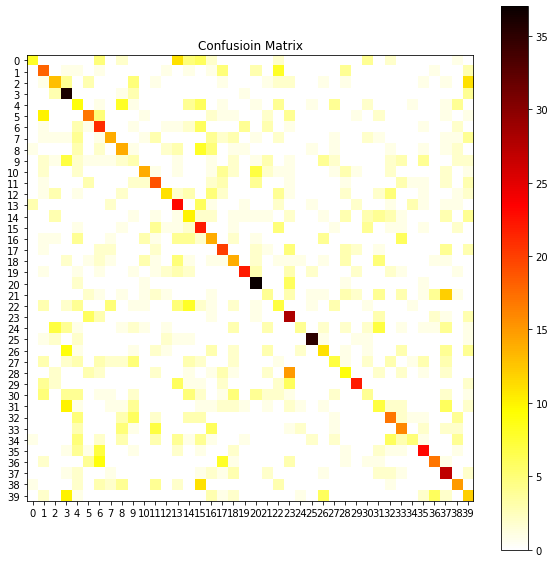

Accuracy of each class:
 tensor([0.1667, 0.3750, 0.2708, 0.7500, 0.1875, 0.3542, 0.4375, 0.2917, 0.2917,
        0.0625, 0.2917, 0.3958, 0.2292, 0.4792, 0.2083, 0.4583, 0.2917, 0.4167,
        0.2917, 0.4583, 0.7708, 0.0833, 0.1458, 0.5833, 0.0833, 0.7292, 0.2292,
        0.1458, 0.1875, 0.4583, 0.0833, 0.1458, 0.3542, 0.3333, 0.1042, 0.4792,
        0.3542, 0.5625, 0.3125, 0.2500])
Recall of each class:
 tensor([0.5714, 0.3000, 0.3421, 0.3830, 0.1268, 0.4048, 0.2877, 0.4242, 0.2800,
        0.0732, 0.5000, 0.3393, 0.4783, 0.3026, 0.1754, 0.2558, 0.2295, 0.3448,
        0.2692, 0.6875, 0.5362, 0.1333, 0.1522, 0.3218, 0.3636, 0.7955, 0.3235,
        0.2692, 0.2308, 0.6667, 0.1481, 0.1628, 0.3333, 0.3265, 0.3846, 0.4894,
        0.5312, 0.3214, 0.3409, 0.1818])
Epoch 10/40: , lr = 0.05
Step [10/60] Train Loss: 1.5819
Step [20/60] Train Loss: 1.3555
Step [30/60] Train Loss: 1.4456
Step [40/60] Train Loss: 1.6006
Step [50/60] Train Loss: 1.4173
Step [60/60] Train Loss: 1.6267
Accuracy on T

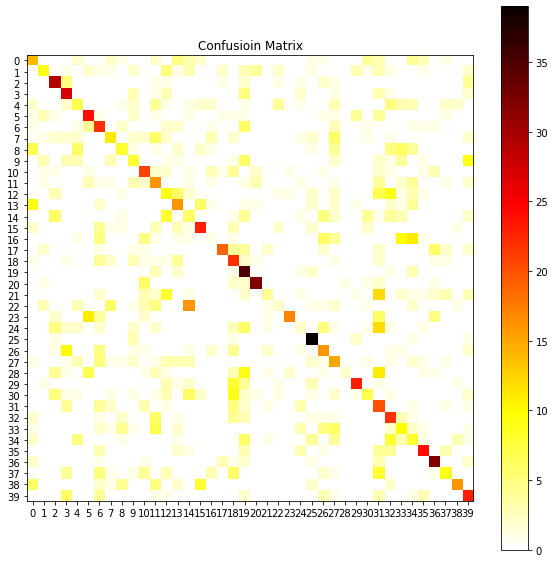

Accuracy of each class:
 tensor([0.2917, 0.1875, 0.6042, 0.5625, 0.1458, 0.5000, 0.4583, 0.2292, 0.1667,
        0.1667, 0.4375, 0.3333, 0.1875, 0.3333, 0.1250, 0.4792, 0.0208, 0.3958,
        0.4583, 0.7292, 0.6667, 0.0833, 0.0417, 0.3542, 0.0417, 0.8125, 0.3333,
        0.3125, 0.0417, 0.4792, 0.1458, 0.4167, 0.4583, 0.2083, 0.1667, 0.5000,
        0.6667, 0.1875, 0.3333, 0.4792])
Recall of each class:
 tensor([0.2745, 0.3600, 0.4833, 0.3857, 0.1944, 0.4615, 0.2716, 0.3235, 0.2963,
        0.2051, 0.3750, 0.2133, 0.1552, 0.2909, 0.1200, 0.5111, 0.0556, 0.7037,
        0.2558, 0.3070, 0.7273, 0.2857, 0.1429, 0.8095, 0.0952, 0.5821, 0.2963,
        0.2273, 0.6667, 0.6571, 0.2917, 0.1739, 0.3014, 0.2041, 0.1429, 0.5714,
        0.6038, 0.3600, 0.6667, 0.3770])
Epoch 11/40: , lr = 0.05
Step [10/60] Train Loss: 1.3366
Step [20/60] Train Loss: 1.4259
Step [30/60] Train Loss: 1.3664
Step [40/60] Train Loss: 1.2348
Step [50/60] Train Loss: 1.6942
Step [60/60] Train Loss: 1.2557
Accuracy on T

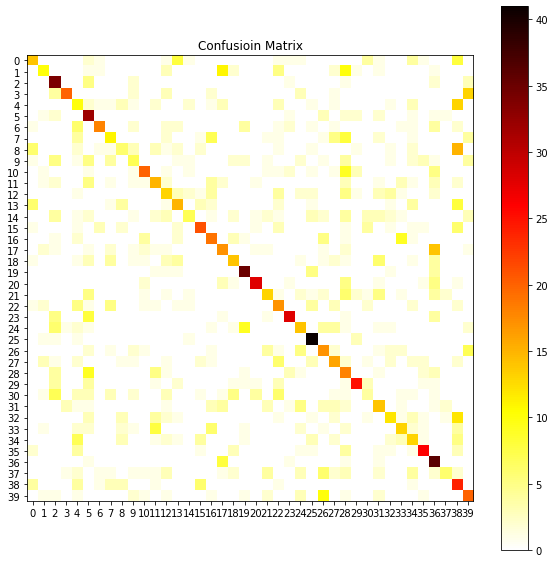

Accuracy of each class:
 tensor([0.2917, 0.2083, 0.7083, 0.4167, 0.2083, 0.6667, 0.3750, 0.2292, 0.1250,
        0.1458, 0.4167, 0.3125, 0.2708, 0.3125, 0.1458, 0.4375, 0.3958, 0.3542,
        0.2917, 0.7292, 0.5833, 0.2708, 0.3542, 0.5833, 0.2917, 0.8542, 0.3542,
        0.3333, 0.3750, 0.5208, 0.0833, 0.2917, 0.2500, 0.2708, 0.2708, 0.5417,
        0.7500, 0.1250, 0.5000, 0.4167])
Recall of each class:
 tensor([0.3784, 0.4167, 0.4146, 0.8000, 0.1587, 0.3232, 0.6667, 0.2895, 0.2222,
        0.2258, 0.5714, 0.3261, 0.2500, 0.3333, 0.4118, 0.5000, 0.3585, 0.3333,
        0.3889, 0.6250, 0.7568, 0.3939, 0.2881, 0.6829, 0.3111, 0.5942, 0.2982,
        0.3333, 0.1818, 0.6579, 0.1739, 0.2917, 0.3750, 0.3514, 0.2549, 0.6341,
        0.3673, 0.5000, 0.2202, 0.3509])
Epoch 12/40: , lr = 0.05
Step [10/60] Train Loss: 1.3312
Step [20/60] Train Loss: 1.3442
Step [30/60] Train Loss: 1.4667
Step [40/60] Train Loss: 1.6218
Step [50/60] Train Loss: 1.4454
Step [60/60] Train Loss: 1.3227
Accuracy on T

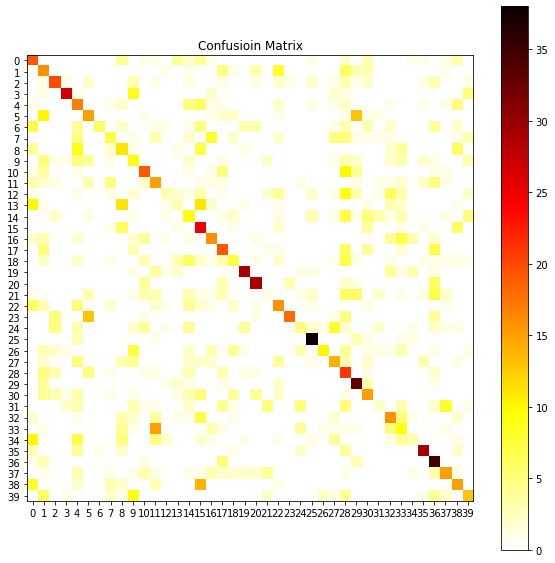

Accuracy of each class:
 tensor([0.3958, 0.3333, 0.4167, 0.5625, 0.3542, 0.3125, 0.1250, 0.1458, 0.2292,
        0.1875, 0.3958, 0.3125, 0.0625, 0.0625, 0.1875, 0.5208, 0.3333, 0.3958,
        0.1458, 0.6042, 0.6042, 0.0208, 0.3333, 0.3750, 0.1042, 0.7917, 0.2083,
        0.2917, 0.4375, 0.6875, 0.3125, 0.0417, 0.3333, 0.1875, 0.0625, 0.6042,
        0.7292, 0.3125, 0.3125, 0.2708])
Recall of each class:
 tensor([0.2405, 0.1951, 0.4762, 0.7941, 0.1977, 0.3261, 0.8571, 0.2414, 0.1964,
        0.1429, 0.3958, 0.2459, 0.2143, 0.1500, 0.1552, 0.2551, 0.3333, 0.3065,
        0.2333, 0.6744, 0.6170, 0.0588, 0.3077, 0.8182, 0.2273, 0.6909, 0.7143,
        0.3111, 0.1694, 0.4286, 0.2941, 0.1429, 0.3137, 0.1667, 0.2143, 0.6744,
        0.3804, 0.4054, 0.3125, 0.3714])
Epoch 13/40: , lr = 0.025
Step [10/60] Train Loss: 1.1952
Step [20/60] Train Loss: 1.0398
Step [30/60] Train Loss: 1.2264
Step [40/60] Train Loss: 1.2672
Step [50/60] Train Loss: 1.1599
Step [60/60] Train Loss: 1.1276
Accuracy on 

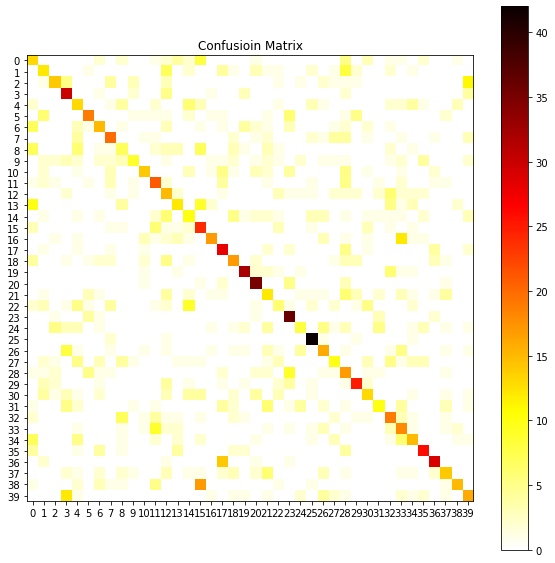

Accuracy of each class:
 tensor([0.2708, 0.2500, 0.2917, 0.6250, 0.2708, 0.3958, 0.3125, 0.4167, 0.1458,
        0.1875, 0.2917, 0.4375, 0.3125, 0.2500, 0.2083, 0.5000, 0.3542, 0.5833,
        0.3542, 0.6667, 0.7292, 0.2500, 0.1250, 0.7500, 0.1667, 0.8750, 0.3333,
        0.2083, 0.3542, 0.5208, 0.2708, 0.2083, 0.3958, 0.3750, 0.3125, 0.5417,
        0.6042, 0.2917, 0.3125, 0.3333])
Recall of each class:
 tensor([0.2000, 0.2791, 0.4667, 0.4000, 0.2167, 0.5278, 0.3488, 0.4167, 0.1795,
        0.4500, 0.5185, 0.3559, 0.1923, 0.3333, 0.2128, 0.3038, 0.6296, 0.3944,
        0.3778, 0.6531, 0.5469, 0.2182, 0.2069, 0.4865, 0.3333, 0.6667, 0.3404,
        0.3125, 0.2000, 0.5682, 0.3421, 0.4000, 0.3333, 0.2609, 0.3571, 0.5652,
        0.6444, 0.4118, 0.6250, 0.3478])
Epoch 14/40: , lr = 0.025
Step [10/60] Train Loss: 1.2573
Step [20/60] Train Loss: 1.0900
Step [30/60] Train Loss: 1.0500
Step [40/60] Train Loss: 1.2409
Step [50/60] Train Loss: 1.1663
Step [60/60] Train Loss: 1.1401
Accuracy on 

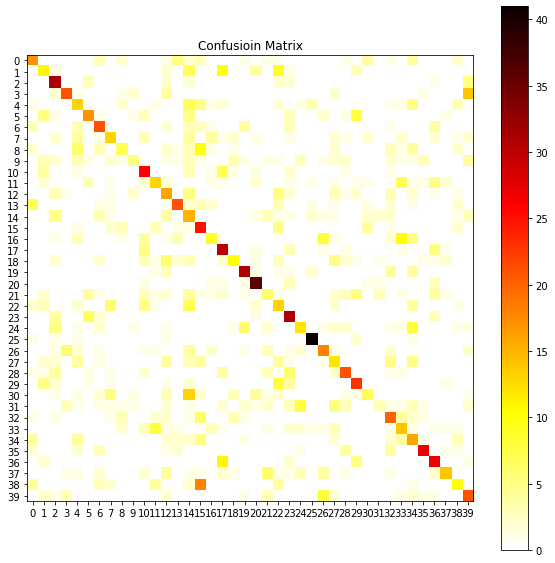

Accuracy of each class:
 tensor([0.3542, 0.2292, 0.6458, 0.4375, 0.2708, 0.3542, 0.4375, 0.2708, 0.1458,
        0.1042, 0.5417, 0.2708, 0.3333, 0.4375, 0.3125, 0.5208, 0.1875, 0.6250,
        0.2083, 0.6458, 0.7500, 0.1250, 0.2708, 0.6458, 0.2500, 0.8542, 0.3750,
        0.2500, 0.4375, 0.4792, 0.1458, 0.0625, 0.4167, 0.2917, 0.3333, 0.5625,
        0.5625, 0.2917, 0.2083, 0.4375])
Recall of each class:
 tensor([0.3778, 0.2619, 0.4306, 0.6000, 0.2407, 0.4595, 0.3962, 0.3421, 0.3043,
        0.3846, 0.4127, 0.3611, 0.2222, 0.5385, 0.1429, 0.2874, 0.3333, 0.3947,
        0.4000, 0.6078, 0.6429, 0.1875, 0.1970, 0.4189, 0.3750, 0.8039, 0.3913,
        0.2264, 0.4667, 0.4510, 0.3182, 0.3000, 0.3279, 0.2800, 0.2286, 0.7297,
        0.4500, 0.5833, 0.3226, 0.3750])
Epoch 15/40: , lr = 0.025
Step [10/60] Train Loss: 0.9831
Step [20/60] Train Loss: 1.1792
Step [30/60] Train Loss: 1.1480
Step [40/60] Train Loss: 1.0769
Step [50/60] Train Loss: 1.2624
Step [60/60] Train Loss: 1.2226
Accuracy on 

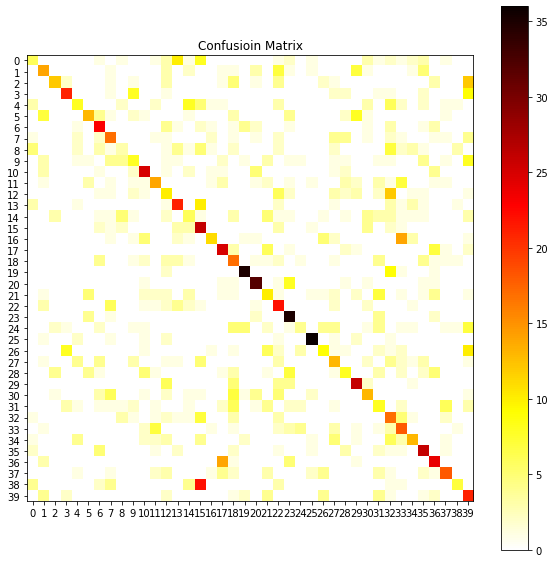

Accuracy of each class:
 tensor([0.1250, 0.2917, 0.2500, 0.4375, 0.1667, 0.2708, 0.4792, 0.3542, 0.0625,
        0.1667, 0.5208, 0.2917, 0.2083, 0.4375, 0.1250, 0.5417, 0.2292, 0.5208,
        0.3542, 0.7292, 0.6667, 0.2083, 0.4583, 0.7292, 0.0833, 0.7500, 0.1875,
        0.2708, 0.1667, 0.5417, 0.2708, 0.1667, 0.3542, 0.3750, 0.2708, 0.5417,
        0.5000, 0.3750, 0.1458, 0.4375])
Recall of each class:
 tensor([0.2308, 0.3333, 0.5455, 0.5676, 0.2963, 0.4333, 0.3833, 0.3333, 0.1429,
        0.2353, 0.4808, 0.3889, 0.1639, 0.3962, 0.1579, 0.2680, 0.5238, 0.4386,
        0.2267, 0.6863, 0.5818, 0.2128, 0.2716, 0.4430, 0.2667, 0.7660, 0.3000,
        0.2549, 0.2500, 0.4815, 0.3333, 0.1509, 0.1932, 0.2609, 0.4062, 0.4262,
        0.4000, 0.4865, 0.4667, 0.2500])
Epoch 16/40: , lr = 0.025
Step [10/60] Train Loss: 1.0471
Step [20/60] Train Loss: 1.1427
Step [30/60] Train Loss: 0.9460
Step [40/60] Train Loss: 1.0971
Step [50/60] Train Loss: 0.9347
Step [60/60] Train Loss: 1.0361
Accuracy on 

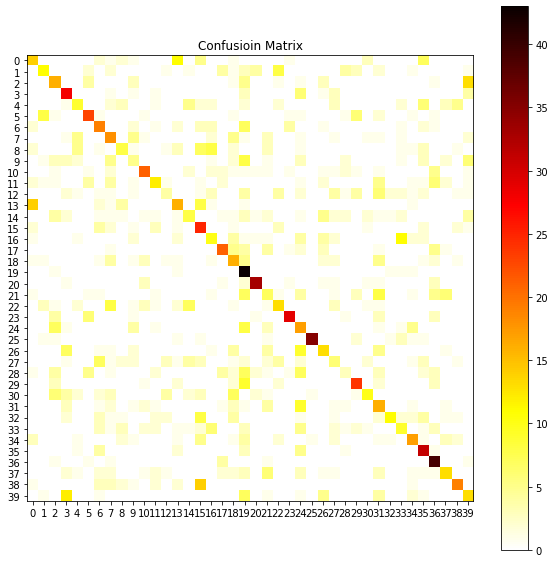

Accuracy of each class:
 tensor([0.2917, 0.2292, 0.3333, 0.5833, 0.1875, 0.4792, 0.3958, 0.3750, 0.1667,
        0.1042, 0.4375, 0.2500, 0.0833, 0.3333, 0.1667, 0.5208, 0.2083, 0.4375,
        0.3333, 0.8958, 0.6875, 0.1458, 0.2708, 0.6042, 0.3542, 0.7292, 0.2708,
        0.1250, 0.0625, 0.5000, 0.2083, 0.3333, 0.2292, 0.1875, 0.3542, 0.6458,
        0.8125, 0.2708, 0.3958, 0.2708])
Recall of each class:
 tensor([0.3182, 0.4074, 0.2963, 0.4000, 0.3000, 0.4894, 0.3167, 0.2609, 0.2857,
        0.1351, 0.5385, 0.3636, 0.2222, 0.3200, 0.2667, 0.2841, 0.2439, 0.5000,
        0.2353, 0.2925, 0.7333, 0.1489, 0.3250, 0.7436, 0.1977, 0.9459, 0.3095,
        0.1667, 0.1579, 0.5217, 0.4545, 0.2162, 0.6471, 0.2432, 0.4146, 0.4189,
        0.4756, 0.3939, 0.5758, 0.2708])
Epoch 17/40: , lr = 0.0125
Step [10/60] Train Loss: 1.0222
Step [20/60] Train Loss: 0.9984
Step [30/60] Train Loss: 1.0019
Step [40/60] Train Loss: 0.8559
Step [50/60] Train Loss: 0.9332
Step [60/60] Train Loss: 0.8898
Accuracy on

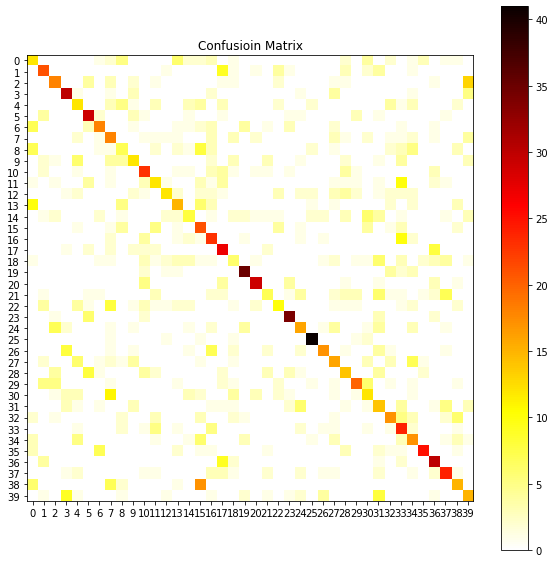

Accuracy of each class:
 tensor([0.2500, 0.4375, 0.3750, 0.6250, 0.2500, 0.6042, 0.3750, 0.3750, 0.1458,
        0.2500, 0.4792, 0.2500, 0.2500, 0.3125, 0.1667, 0.4375, 0.4792, 0.5625,
        0.1250, 0.7292, 0.6042, 0.1458, 0.2083, 0.7083, 0.3333, 0.8542, 0.3542,
        0.3333, 0.2917, 0.4167, 0.2500, 0.2917, 0.3542, 0.5000, 0.3542, 0.5208,
        0.6250, 0.5000, 0.3125, 0.3125])
Recall of each class:
 tensor([0.2308, 0.4468, 0.4390, 0.5172, 0.2500, 0.5000, 0.4865, 0.2500, 0.1795,
        0.3333, 0.4107, 0.2791, 0.5217, 0.3488, 0.2667, 0.2593, 0.3194, 0.3699,
        0.1765, 0.6731, 0.7250, 0.2917, 0.3333, 0.6538, 0.3810, 0.7885, 0.6071,
        0.3265, 0.3111, 0.5882, 0.2667, 0.2090, 0.3953, 0.2927, 0.2881, 0.7353,
        0.5000, 0.4898, 0.3571, 0.3125])
Epoch 18/40: , lr = 0.0125
Step [10/60] Train Loss: 0.7335
Step [20/60] Train Loss: 0.9676
Step [30/60] Train Loss: 0.8190
Step [40/60] Train Loss: 1.0462
Step [50/60] Train Loss: 0.9206
Step [60/60] Train Loss: 0.7814
Accuracy on

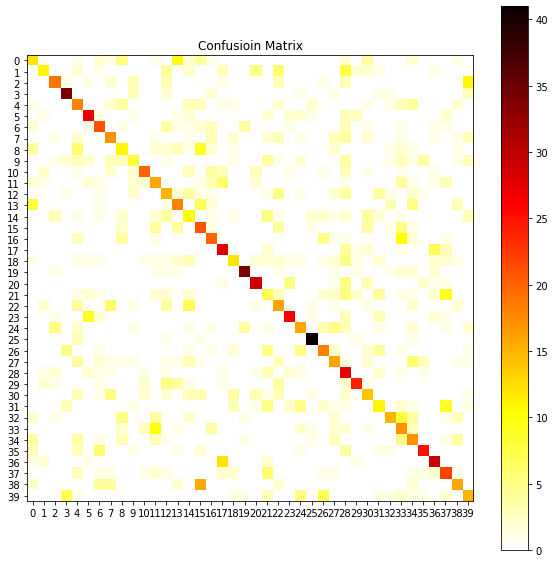

Accuracy of each class:
 tensor([0.2500, 0.2292, 0.3958, 0.7083, 0.3750, 0.5625, 0.4375, 0.3542, 0.2292,
        0.1667, 0.4167, 0.3333, 0.3125, 0.3750, 0.2083, 0.4375, 0.4167, 0.5833,
        0.2500, 0.7083, 0.6042, 0.1458, 0.3333, 0.5417, 0.3333, 0.8542, 0.3750,
        0.3333, 0.5625, 0.5000, 0.2917, 0.2292, 0.3125, 0.3542, 0.3542, 0.5208,
        0.6042, 0.4583, 0.3333, 0.3125])
Recall of each class:
 tensor([0.2857, 0.5000, 0.5429, 0.6415, 0.2727, 0.5625, 0.4118, 0.3778, 0.2558,
        0.3077, 0.6250, 0.3200, 0.2679, 0.3529, 0.1923, 0.2958, 0.4082, 0.4746,
        0.4000, 0.7556, 0.6170, 0.1373, 0.2712, 0.6500, 0.3721, 0.7885, 0.4186,
        0.3265, 0.2647, 0.6667, 0.3111, 0.2973, 0.5556, 0.2394, 0.2742, 0.6579,
        0.5577, 0.3729, 0.4324, 0.3409])
Epoch 19/40: , lr = 0.0125
Step [10/60] Train Loss: 1.0087
Step [20/60] Train Loss: 1.0595
Step [30/60] Train Loss: 0.8284
Step [40/60] Train Loss: 0.8157
Step [50/60] Train Loss: 0.7601
Step [60/60] Train Loss: 0.9105
Accuracy on

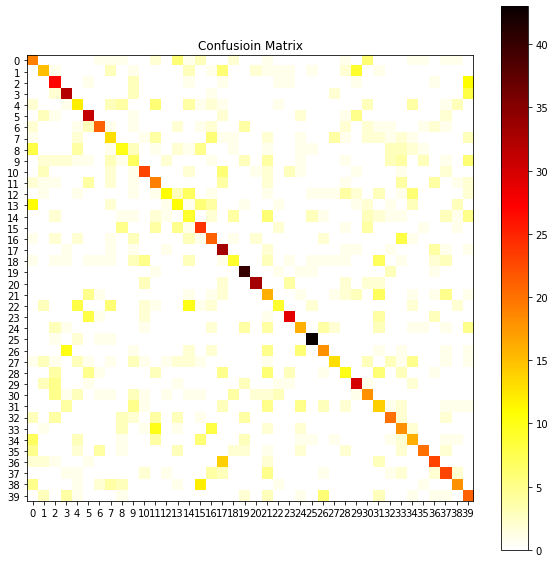

Accuracy of each class:
 tensor([0.3958, 0.3125, 0.5625, 0.6667, 0.2500, 0.6458, 0.4375, 0.2708, 0.2083,
        0.1458, 0.4792, 0.3958, 0.2292, 0.2292, 0.1875, 0.5000, 0.4375, 0.6875,
        0.1875, 0.8333, 0.6875, 0.3333, 0.1875, 0.6042, 0.3333, 0.8958, 0.3750,
        0.2708, 0.2083, 0.6250, 0.3750, 0.2917, 0.4167, 0.3750, 0.3333, 0.4167,
        0.4792, 0.4792, 0.3750, 0.4375])
Recall of each class:
 tensor([0.2714, 0.3750, 0.4286, 0.5517, 0.2553, 0.5000, 0.6176, 0.2766, 0.2941,
        0.1591, 0.5349, 0.3065, 0.5789, 0.2750, 0.1731, 0.3810, 0.3500, 0.3929,
        0.3750, 0.6061, 0.8250, 0.2051, 0.4286, 0.6744, 0.3902, 0.7963, 0.4737,
        0.5200, 0.2941, 0.5556, 0.3913, 0.2373, 0.5000, 0.3103, 0.3333, 0.6897,
        0.5111, 0.4340, 0.5294, 0.3088])
Epoch 20/40: , lr = 0.0125
Step [10/60] Train Loss: 0.7424
Step [20/60] Train Loss: 0.7906
Step [30/60] Train Loss: 0.9798
Step [40/60] Train Loss: 0.9123
Step [50/60] Train Loss: 1.1521
Step [60/60] Train Loss: 0.9599
Accuracy on

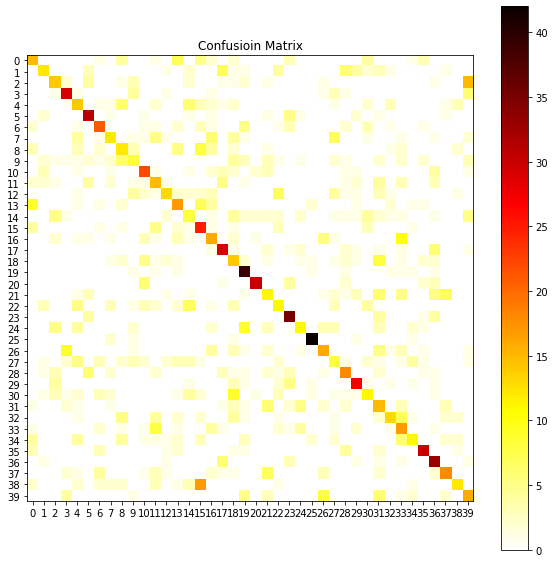

Accuracy of each class:
 tensor([0.3125, 0.2500, 0.2917, 0.6042, 0.2917, 0.6458, 0.4375, 0.2500, 0.2500,
        0.1667, 0.4583, 0.3125, 0.2708, 0.3542, 0.1667, 0.5208, 0.3333, 0.6042,
        0.2917, 0.8125, 0.6250, 0.2292, 0.2292, 0.7292, 0.2292, 0.8750, 0.3333,
        0.1667, 0.3750, 0.5625, 0.2292, 0.3125, 0.2708, 0.3542, 0.2292, 0.6250,
        0.6875, 0.3750, 0.2500, 0.3333])
Recall of each class:
 tensor([0.3261, 0.4286, 0.3590, 0.5472, 0.2593, 0.5345, 0.4565, 0.3636, 0.2500,
        0.2353, 0.4400, 0.2632, 0.4643, 0.3148, 0.1860, 0.3205, 0.2759, 0.4915,
        0.2029, 0.4875, 0.8333, 0.2292, 0.2683, 0.5385, 0.3929, 0.8400, 0.3902,
        0.1951, 0.3750, 0.5510, 0.2973, 0.2055, 0.4815, 0.2576, 0.4074, 0.6522,
        0.4714, 0.4865, 0.5217, 0.3077])
Epoch 21/40: , lr = 0.00625


KeyboardInterrupt: 

In [10]:
fit(net, num_epochs, optimizer, schedulr,device, nclasses)  #